In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

load data

In [2]:
rootpath = "../data"
sub_id = "dy009"
samp_freq = 30_000

In [3]:
# load unsorted data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=True, samp_freq=samp_freq)

In [4]:
# load sorted data
ks_spikes_times, ks_spikes_clusters, ks_spikes_amps, ks_spikes_depths, sorted, ks_trials = \
    data_preprocess.load_kilosort_sorted_data(rootpath, sub_id, keep_active_trials=True, samp_freq=samp_freq)

In [5]:
# load sorted data
ks_spikes_times, ks_spikes_clusters, ks_spikes_amps, ks_spikes_depths, sorted, ks_trials = \
    data_preprocess.load_kilosort_sorted_data(rootpath, sub_id, keep_active_trials=True, samp_freq=samp_freq)

In [6]:
# load kilosort units that passed ibl's quality metrics
good_ks_spikes_indices = data_preprocess.load_kilosort_good_ibl_units(rootpath, sub_id, roi='all', keep_active_trials = True, samp_freq=30_000)

In [7]:
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

In [8]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = True)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


initialize gmm using k-means++ (recommended and faster than k-means)

In [9]:
trials_ids = np.arange(len(trials))
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] # follows time order

In [10]:
initial_gmm = init_gmm.initial_gaussian_mixtures('..', sub_id, trials, n_gaussians=300, seed=seed, fit_model=True)

In [11]:
initial_labels = initial_gmm.predict(structured_unsorted)
initial_probs = initial_gmm.predict_proba(structured_unsorted)

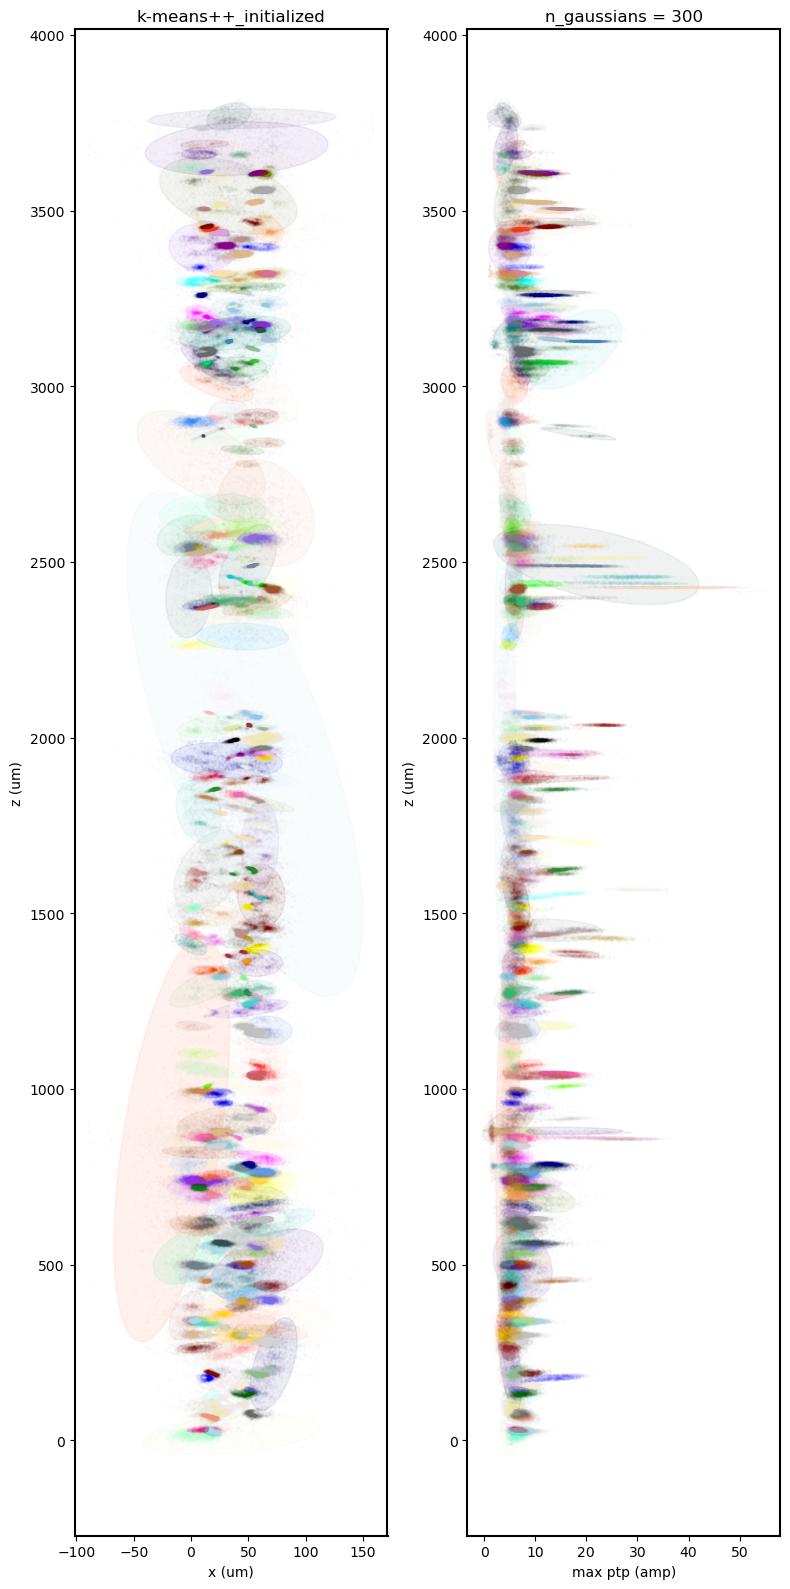

In [13]:
viz_tools.plot_gmm_cluster_viz(sub_id, structured_unsorted, initial_labels, initial_labels, n_spikes_display=10_000, title='k-means++_initialized', save_fig=False)

In [14]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, initial_labels, initial_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 300, 30)
clusterless neural projections shape: (230, 300, 15)
clusterless neural reconstructions shape: (230, 300, 30)


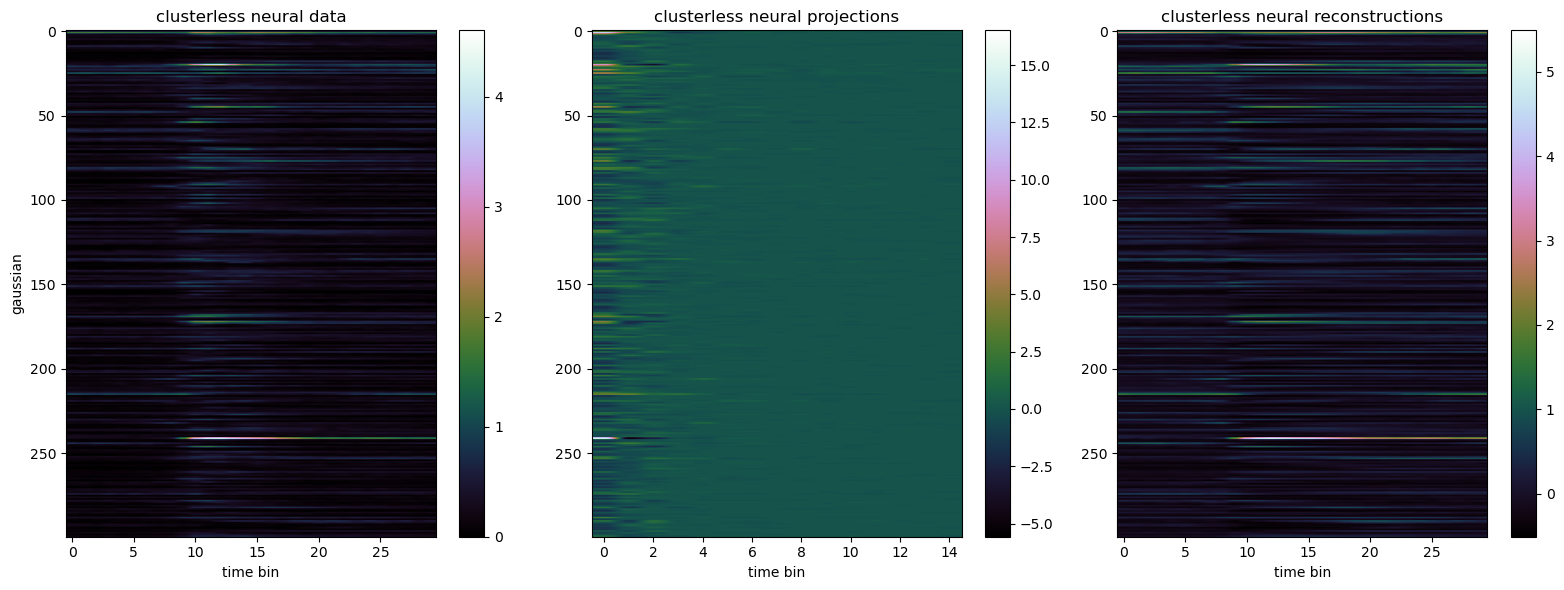

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [16]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.913 auc: 0.983
choice fold 2 test accuracy: 0.935 auc: 0.979
choice fold 3 test accuracy: 0.935 auc: 0.986
choice fold 4 test accuracy: 0.935 auc: 0.982
choice fold 5 test accuracy: 0.978 auc: 0.998
choice mean of 5-fold cv accuracy: 0.939 auc: 0.986
choice sd of 5-fold cv accuracy: 0.021 auc: 0.007
stimulus fold 1 test accuracy: 0.261 auc: 0.776
stimulus fold 2 test accuracy: 0.261 auc: 0.786
stimulus fold 3 test accuracy: 0.348 auc: 0.816
stimulus fold 4 test accuracy: 0.304 auc: 0.799
stimulus fold 5 test accuracy: 0.348 auc: 0.815
stimulus mean of 5-fold cv accuracy: 0.304 auc: 0.799
stimulus sd of 5-fold cv accuracy: 0.039 auc: 0.016


split

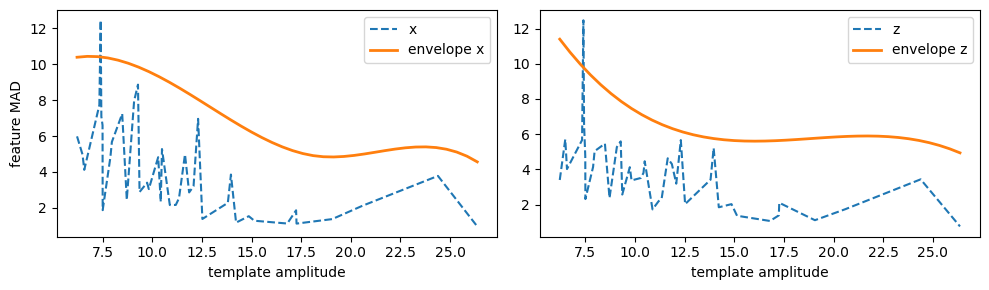

In [13]:
# plot smooth envelope for kilosort template feature MADs

split_ids = split_merge.split_criteria(structured_unsorted, initial_labels, use_ks_template=True)

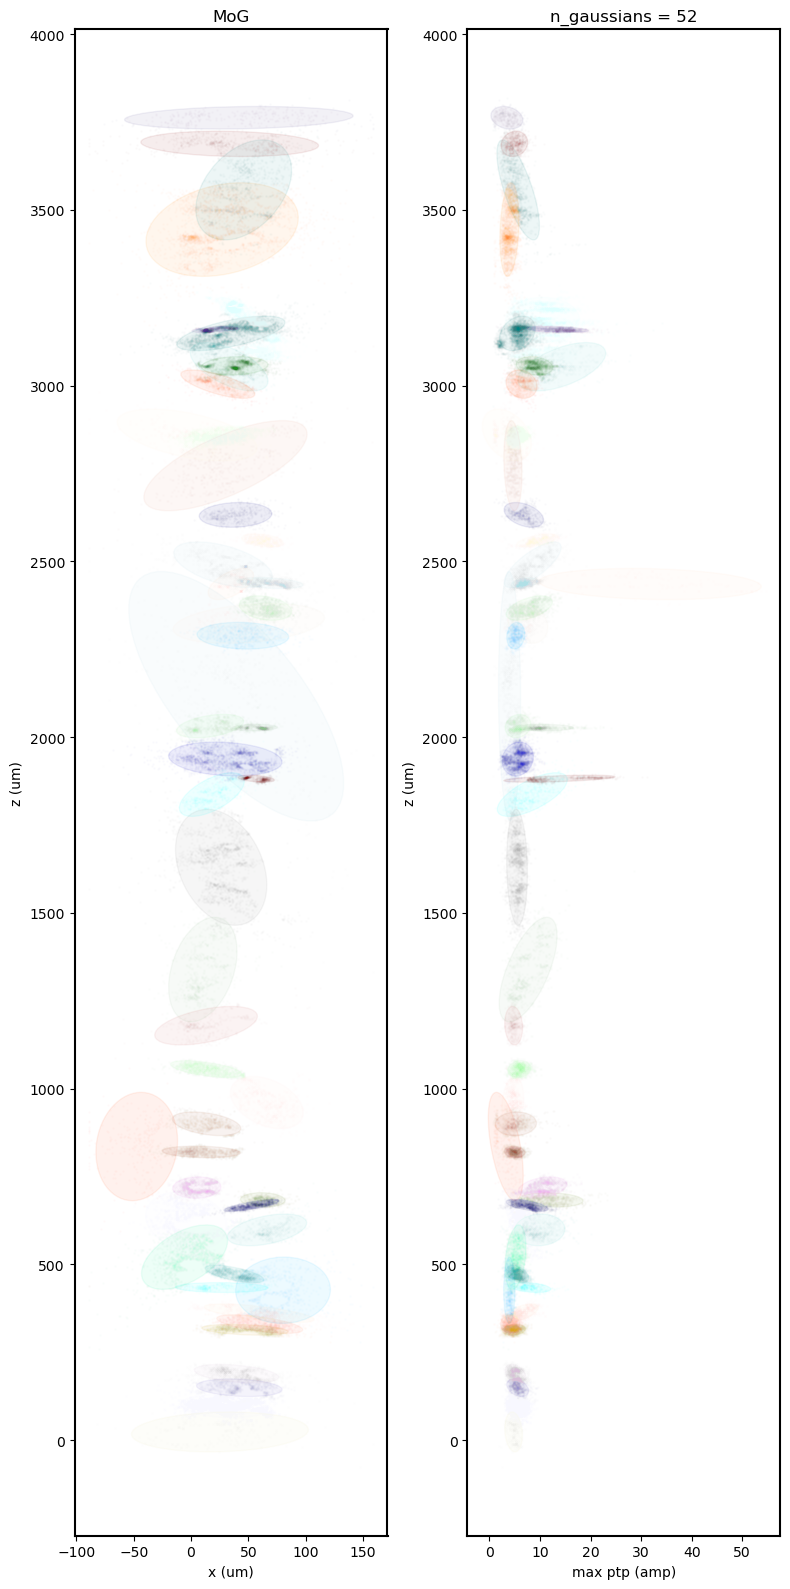

In [14]:
# plot gaussians to be split

viz_tools.plot_gmm_cluster_viz(structured_unsorted, initial_labels, split_ids, n_spikes_display=10_000)

In [16]:
post_split_gmm = split_merge.split_gaussians('.', sub_id, structured_unsorted, initial_gmm, initial_labels, split_ids, init_method='k-means++', fit_model=True)

initial n_gaussians: 350 bic: 13976060.44
keep 298 gaussians and split 52 gaussians ...
pre-split bic: 14440592.3
split gaussian 4 into 2 gaussians with updated bic: 14386171.2
split gaussian 4 into 3 gaussians with updated bic: 14392592.15
split gaussian 6 into 2 gaussians with updated bic: 14305711.69
split gaussian 6 into 3 gaussians with updated bic: 14314474.39
split gaussian 9 into 2 gaussians with updated bic: 14291266.44
split gaussian 9 into 3 gaussians with updated bic: 14291454.39
split gaussian 10 into 2 gaussians with updated bic: 14223505.77
split gaussian 10 into 3 gaussians with updated bic: 14227399.74
split gaussian 12 into 2 gaussians with updated bic: 14181176.58
split gaussian 12 into 3 gaussians with updated bic: 14186738.65
split gaussian 33 into 2 gaussians with updated bic: 14081829.11
split gaussian 33 into 3 gaussians with updated bic: 14087640.57
split gaussian 81 into 2 gaussians with updated bic: 13943922.06
split gaussian 81 into 3 gaussians with updated 

In [17]:
post_split_gmm = split_merge.split_gaussians('.', sub_id, structured_unsorted, initial_gmm, initial_labels, split_ids, init_method='k-means++', fit_model=False)
post_split_labels = post_split_gmm.predict(structured_unsorted)
post_split_probs = post_split_gmm.predict_proba(structured_unsorted)

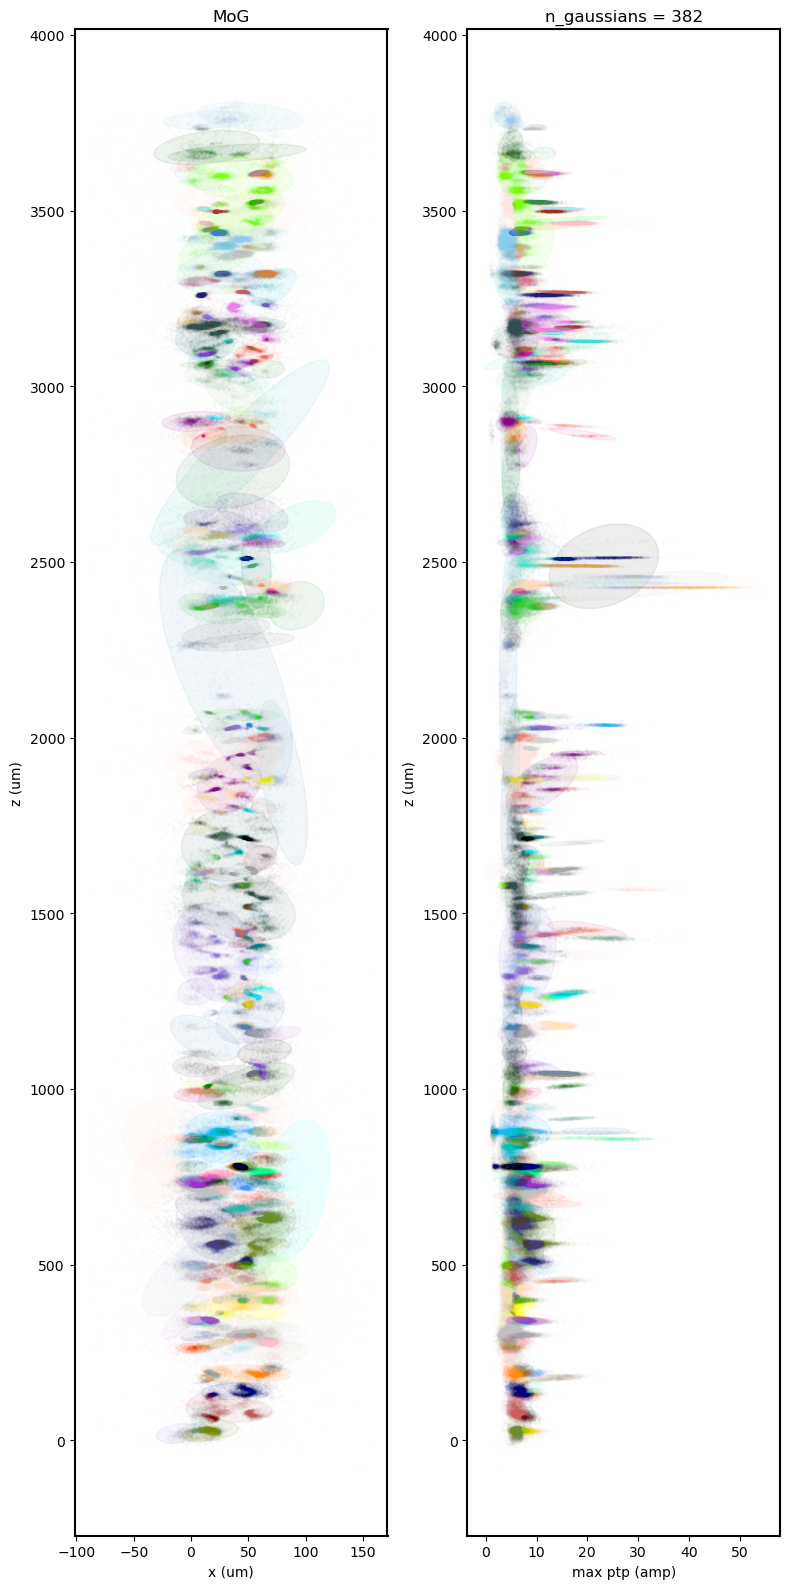

In [18]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, post_split_labels, post_split_labels, n_spikes_display=30_000)

merge

In [19]:
corr_mat = split_merge.calc_corr_matrix(post_split_probs)
np.save(f'pretrained/{sub_id}/corr_mat.npy', corr_mat)
# corr_mat = np.load(f'pretrained/{sub_id}/corr_mat.npy')

calculaing corr for pair (0, 50) ...
calculaing corr for pair (0, 100) ...
calculaing corr for pair (0, 150) ...
calculaing corr for pair (0, 200) ...
calculaing corr for pair (0, 250) ...
calculaing corr for pair (0, 300) ...
calculaing corr for pair (0, 350) ...
calculaing corr for pair (0, 400) ...
calculaing corr for pair (50, 100) ...
calculaing corr for pair (50, 150) ...
calculaing corr for pair (50, 200) ...
calculaing corr for pair (50, 250) ...
calculaing corr for pair (50, 300) ...
calculaing corr for pair (50, 350) ...
calculaing corr for pair (50, 400) ...
calculaing corr for pair (100, 150) ...
calculaing corr for pair (100, 200) ...
calculaing corr for pair (100, 250) ...
calculaing corr for pair (100, 300) ...
calculaing corr for pair (100, 350) ...
calculaing corr for pair (100, 400) ...
calculaing corr for pair (150, 200) ...
calculaing corr for pair (150, 250) ...
calculaing corr for pair (150, 300) ...
calculaing corr for pair (150, 350) ...
calculaing corr for pair

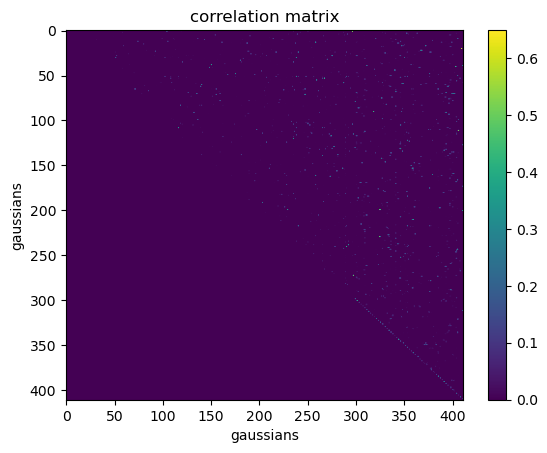

In [21]:
plt.imshow(corr_mat, cmap='viridis', aspect='auto')
plt.xlabel('gaussians')
plt.ylabel('gaussians')
plt.title('correlation matrix')
plt.colorbar();

In [25]:
merge_ids = split_merge.merge_criteria(corr_mat, 0.55)
print(len(merge_ids))

8


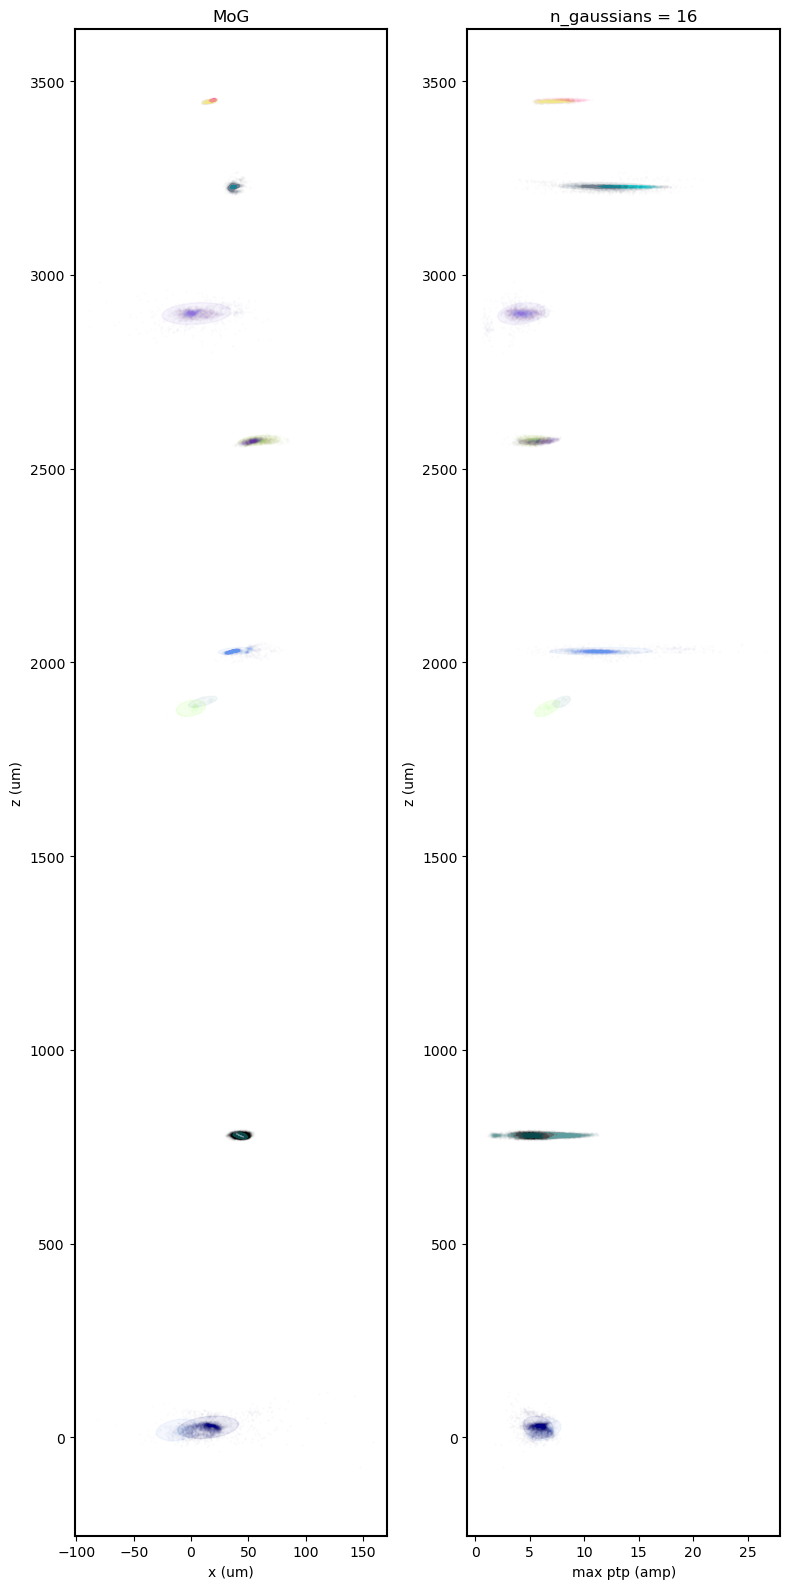

In [26]:
viz_tools.plot_gmm_cluster_viz(structured_unsorted, post_split_labels, np.unique(merge_ids), n_spikes_display=30_000)

In [27]:
post_merge_gmm = split_merge.merge_gaussians('.', sub_id, structured_unsorted, post_split_gmm, post_split_labels, merge_ids, init_method='k_means++', fit_model=True)

initial n_gaussians: 411 bic: 12395269.49
keep 367 gaussians and merge 8 gaussians ...
pre-merge bic: 12606233.45
merge pairs 1 and 296 with updated bic: 12430512.45
merge pairs 20 and 409 with updated bic: 12349051.53
merge pairs 44 and 340 with updated bic: 12297942.76
merge pairs 53 and 267 with updated bic: 12265328.71
merge pairs 55 and 259 with updated bic: 12237916.23
merge pairs 111 and 406 with updated bic: 12205408.34
merge pairs 272 and 297 with updated bic: 12197719.38
merge pairs 343 and 344 with updated bic: 12153892.47


In [15]:
post_merge_gmm = split_merge.merge_gaussians('.', sub_id, structured_unsorted, post_split_gmm=None, post_split_labels=None, merge_ids=None, init_method='k-means++', fit_model=False)

In [16]:
post_merge_labels = post_merge_gmm.predict(structured_unsorted)
post_merge_probs = post_merge_gmm.predict_proba(structured_unsorted)

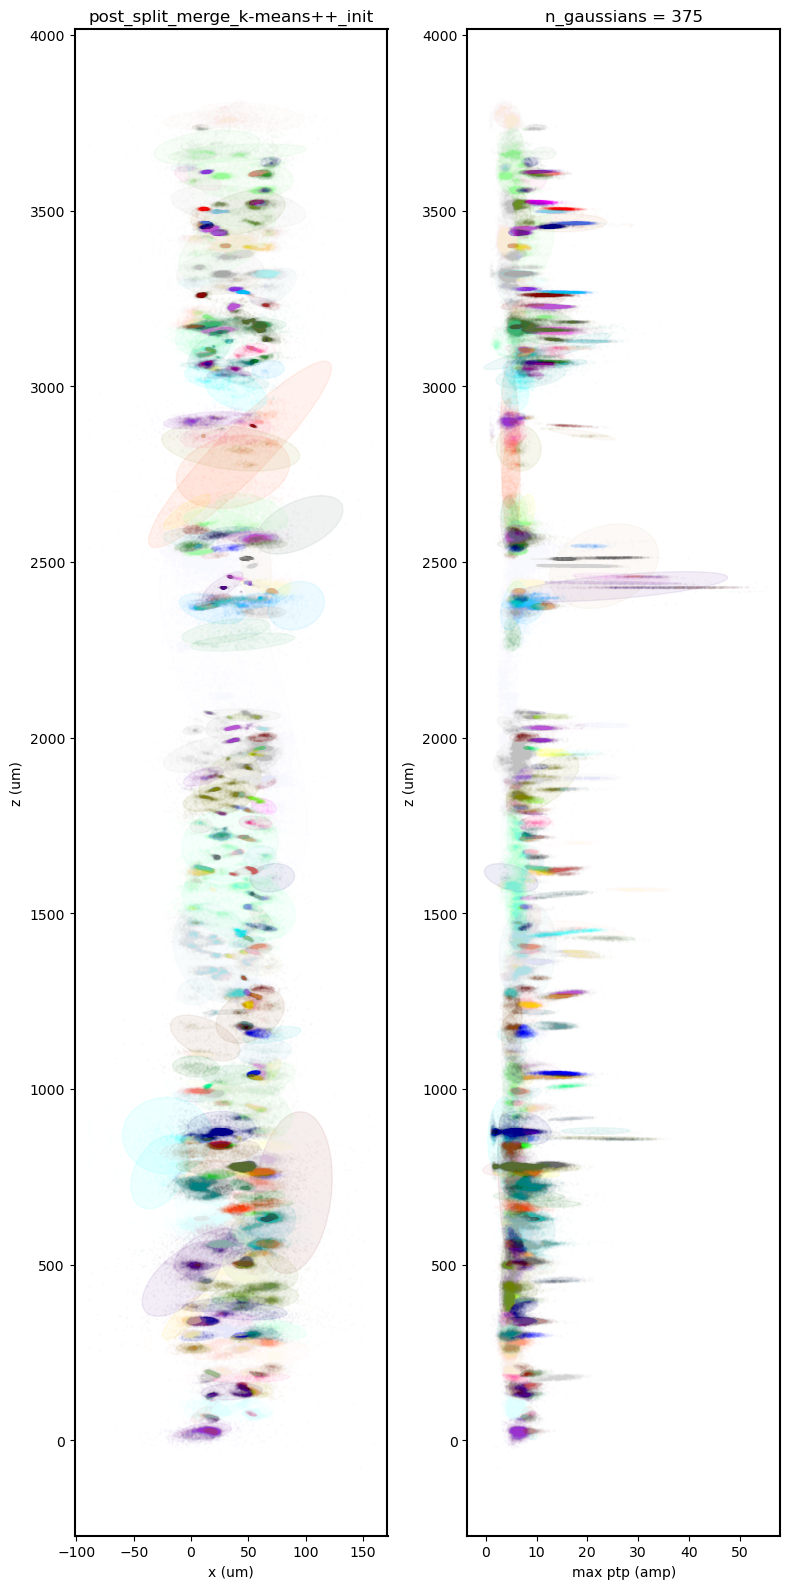

In [17]:
viz_tools.plot_gmm_cluster_viz(sub_id, structured_unsorted, post_merge_labels, post_merge_labels, n_spikes_display=30_000, title='post_split_merge_k-means++_init', save_fig=True)

In [31]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, post_merge_labels, post_merge_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 375, 30)
clusterless neural projections shape: (230, 375, 15)
clusterless neural reconstructions shape: (230, 375, 30)


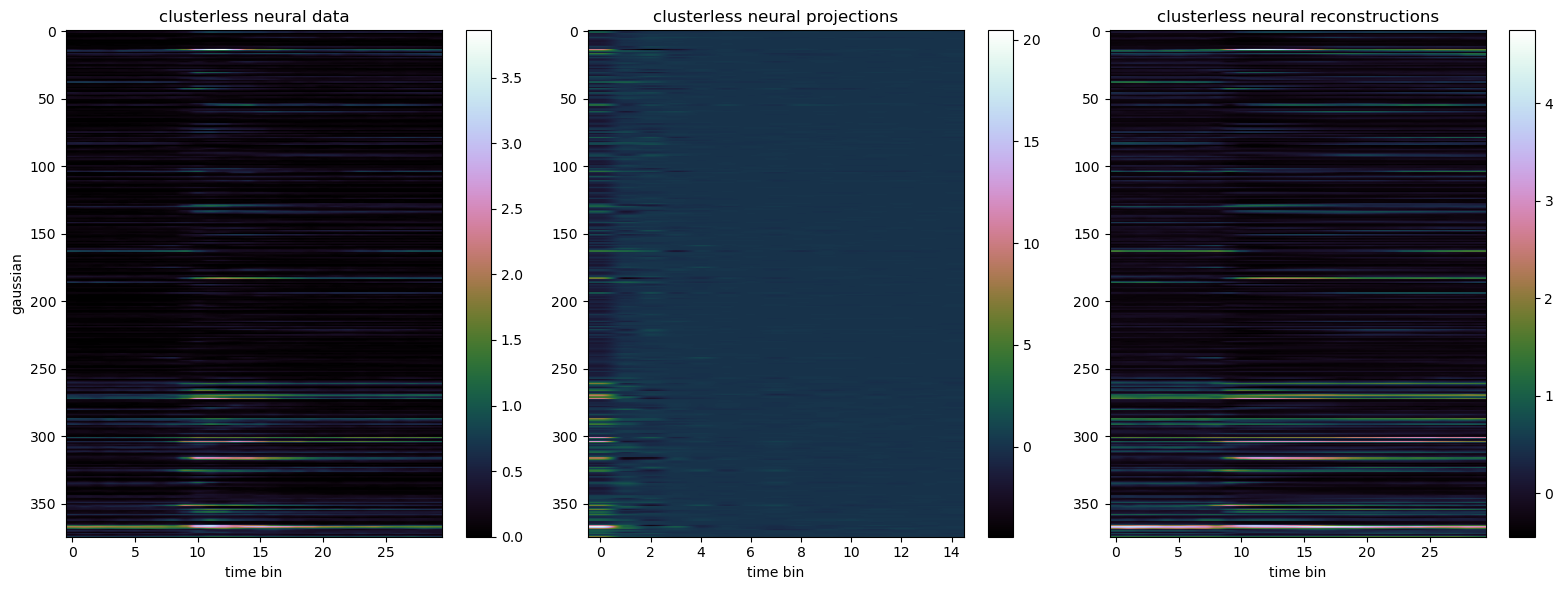

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [33]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.913 auc: 0.996
choice fold 2 test accuracy: 0.935 auc: 0.994
choice fold 3 test accuracy: 0.848 auc: 0.951
choice fold 4 test accuracy: 0.978 auc: 0.994
choice fold 5 test accuracy: 0.978 auc: 0.998
choice mean of 5-fold cv accuracy: 0.930 auc: 0.987
choice sd of 5-fold cv accuracy: 0.048 auc: 0.018
stimulus fold 1 test accuracy: 0.239 auc: 0.796
stimulus fold 2 test accuracy: 0.348 auc: 0.823
only one class present in y_true, auc score is not defined in that case.
stimulus fold 3 test accuracy: 0.152 auc: nan
stimulus fold 4 test accuracy: 0.196 auc: 0.806
stimulus fold 5 test accuracy: 0.391 auc: 0.848
stimulus mean of 5-fold cv accuracy: 0.265 auc: 0.818
stimulus sd of 5-fold cv accuracy: 0.091 auc: 0.020
